In [1]:
import sys
sys.path.append('../')

import os.path
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import muram as muram
import muram_eos as muram_eos

Importing muram_eos.py


In [2]:
# Make sure you load here the same table as used later when running the code
path='../../RUNDIR/'
eos=muram_eos.mu_eos(path+'Uppsala_mergedeos_PI_A.dat')

3000 1250 600 300
1941013576720.3928 1018055818001036.4
9.999984707689917e-19 0.005999990971812534
54.598150033144236 195729609428.83878
500000000.0 1000000000.0


In [3]:
# We need some inverse table relations. We use a Newton-Raphson interastion for that. If this does not converge reduce stp.

# P,T -> rho ,eps
def invert_eos(pres=1e5,temp=1e4,eos=eos,tol=1e-5,fct=1.01,stp=1.0,itmax=100,rho_0=3e-7,eps_0=3e12):

    it_max=10

    rho=rho_0
    eps=eps_0

    p1=eos.interp_p(eps,rho)
    t1=eos.interp_T(eps,rho)

    #print(p1,t1,rho,eps)
 
    err=1e99
    it=0
    while (err > tol):
        p_r=(eos.interp_p(eps,fct*rho)-p1)/((fct-1.0)*rho)
        p_e=(eos.interp_p(fct*eps,rho)-p1)/((fct-1.0)*eps)
        t_r=(eos.interp_T(eps,fct*rho)-t1)/((fct-1.0)*rho)
        t_e=(eos.interp_T(fct*eps,rho)-t1)/((fct-1.0)*eps)

        det=p_r*t_e-p_e*t_r

        #print(p_r,p_e,t_r,t_e,det)
        
        r1=( t_e*(pres-p1)-p_e*(temp-t1))/det
        e1=(-t_r*(pres-p1)+p_r*(temp-t1))/det

        #print(r1/rho,e1/eps)

        #rho=r1.clip(1e-20,1e-2)
        #eps=e1.clip(6e11,1e20)

        rho=np.max([1e-20,rho+stp*r1])
        eps=np.max([6e11,eps+stp*e1])

        p1=eos.interp_p(eps,rho)
        t1=eos.interp_T(eps,rho)

        it+=1

        err_p=np.max(np.abs(1.0-p1/pres))
        err_t=np.max(np.abs(1.0-t1/temp))
        err=np.max([err_p,err_t])

        if(it>itmax):
            err=0.0
        

    return eps,rho

# P,S -> rho,eps
def invert_eos_entr(pres=1e5,entr=1.8e9,eos=eos,tol=1e-5,fct=1.01,stp=1.0,itmax=100,rho_0=3e-7,eps_0=3e12):

    it_max=10

    rho=rho_0
    eps=eps_0

    p1=eos.interp_p(eps,rho)
    s1=eos.interp_s(eps,rho)

    #print(p1,t1,rho,eps)
 
    err=1e99
    it=0
    while (err > tol):
        p_r=(eos.interp_p(eps,fct*rho)-p1)/((fct-1.0)*rho)
        p_e=(eos.interp_p(fct*eps,rho)-p1)/((fct-1.0)*eps)
        s_r=(eos.interp_s(eps,fct*rho)-s1)/((fct-1.0)*rho)
        s_e=(eos.interp_s(fct*eps,rho)-s1)/((fct-1.0)*eps)

        det=p_r*s_e-p_e*s_r

        #print(p_r,p_e,t_r,t_e,det)
        
        r1=( s_e*(pres-p1)-p_e*(entr-s1))/det
        e1=(-s_r*(pres-p1)+p_r*(entr-s1))/det

        #print(r1/rho,e1/eps)

        #rho=r1.clip(1e-20,1e
        #eps=e1.clip(6e11,1e20)

        rho=np.max([1e-20,rho+stp*r1])
        eps=np.max([6e11,eps+stp*e1])

        p1=eos.interp_p(eps,rho)
        s1=eos.interp_s(eps,rho)

        it+=1

        err_p=np.max(np.abs(1.0-p1/pres))
        err_s=np.max(np.abs(1.0-s1/entr))
        err=np.max([err_p,err_s])

        if(it>itmax):
            err=0.0
        

    return eps,rho

In [4]:
# We compute here an adiabatic statification to initialize a new run from scratch
s_bot=9.78e+08  # This value leads to a energy flux of about 6.3e10 erg/cm^2/s once fully relaxed (somewhat dependent on opacity table used)
                # Fine tune this value if necessary, only small changes (0.1-1% level) should be required for a solar-like setup 

p_bot=3.0e7    # For a different box depth adjust such that T at the top of the domain is around 3,000 K. 
               # Once relaxed, tau=1 will be about 700km benath the top boundary with that choice.

nx=96
ny=192
nz=192

dx=32e5
dy=48e5
dz=48e5

p=p_bot
rho=np.zeros(nx)
eint=np.zeros(nx)

rho_last=eos.interp_rho(p,s_bot)
eps_last=eos.interp_eps(p,s_bot)

rho[0] = rho_last
eint[0]= rho_last*eps_last

for i in range(1,nx):

    p -= dx*2.74e4*rho_last
    
    eps_last,rho_last=invert_eos_entr(pres=p,entr=s_bot,eos=eos,rho_0=rho_last,eps_0=eps_last)
    
    rho[i] = rho_last
    eint[i]= rho_last*eps_last

print(eos.interp_T(eint[-1]/rho[-1],rho[-1]))

2778.9510482630003


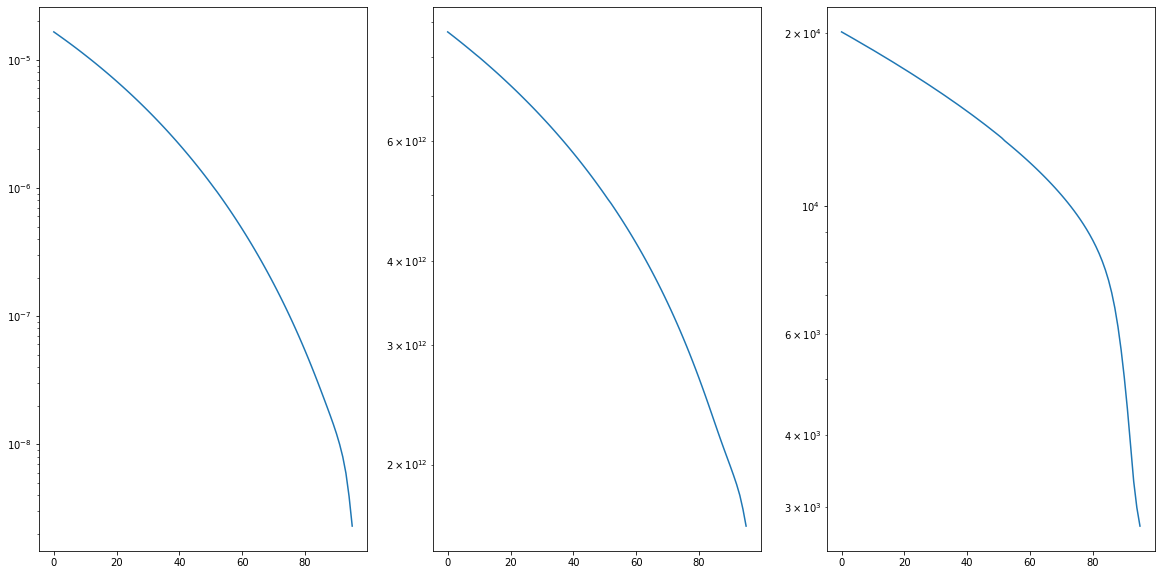

In [5]:
plt.figure(figsize=(20,10))
plt.subplot(131)
plt.plot(rho)
plt.yscale("log")
plt.subplot(132)
plt.plot(eint/rho)
plt.yscale("log")
plt.subplot(133)
plt.plot(eos.interp_T(eint/rho,rho))
plt.yscale("log")

plt.show()

In [6]:
# Expand everything to 3D and add random noise to break horizontal symmetry

rho_3d=np.array([[rho[:],]*ny,]*nz,dtype=np.float32).transpose([2,1,0])
eint_3d=np.array([[eint[:],]*ny,]*nz,dtype=np.float32).transpose([2,1,0])

zeros=np.zeros((nx,ny,nz),dtype=np.float32)
random=(np.random.rand(nx,ny,nz)).astype(np.float32)*1e4

# Initialize the vertical field to 10G. Note the division by sqrt(4*pi)!
Bx_3d=np.ones((nx,ny,nz),dtype=np.float32) * 10/np.sqrt(4*np.pi)

In [7]:
path_out='./Photosphere/3D/'

iter=0

header=np.zeros(9)

header[0]=nx
header[1]=ny
header[2]=nz
header[3]=dx
header[4]=dy
header[5]=dz

filename = path_out+f"Header.{iter:06d}"
string=f"{header[0]:0.0f} {header[1]:0.0f} {header[2]:0.0f} {header[3]:E} {header[4]:E} {header[5]:E} {header[6]:E} {header[7]:E} {header[8]:E}"
with open(filename, "w") as text_file:
    text_file.write(string)

rho_3d.transpose([2,1,0]).tofile(path_out+f'result_prim_0.{iter:06d}')
random.transpose([2,1,0]).tofile(path_out+f'result_prim_1.{iter:06d}')
zeros.transpose([2,1,0]).tofile(path_out+f'result_prim_2.{iter:06d}')
zeros.transpose([2,1,0]).tofile(path_out+f'result_prim_3.{iter:06d}')
eint_3d.transpose([2,1,0]).tofile(path_out+f'result_prim_4.{iter:06d}')
Bx_3d.transpose([2,1,0]).tofile(path_out+f'result_prim_5.{iter:06d}')
zeros.transpose([2,1,0]).tofile(path_out+f'result_prim_6.{iter:06d}')
zeros.transpose([2,1,0]).tofile(path_out+f'result_prim_7.{iter:06d}')

In [8]:
# Now run the photospheric simulation for a few hours to relax with respect to convection. The parameters.dat file has settings for a typical photopsheric run. 
# Note that fully relaxing the small-scale dynamo may take longer at this relatively low resolution.

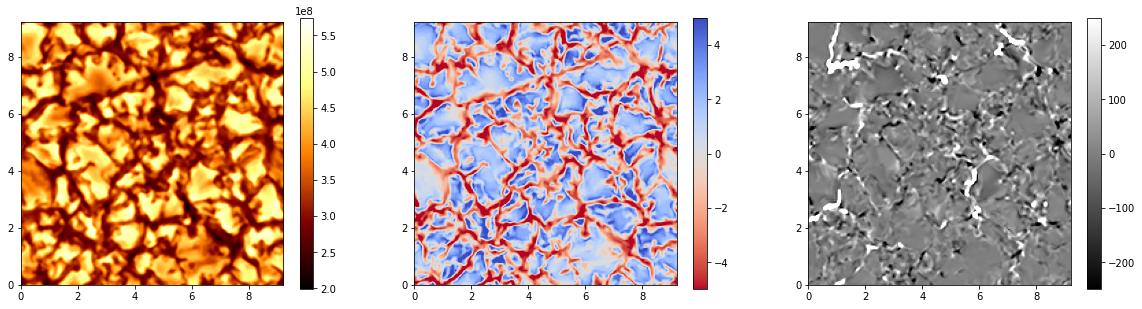

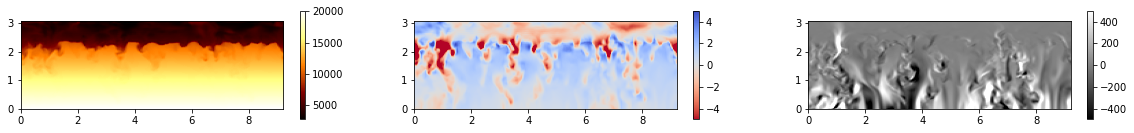

In [9]:
# Look at some 2D-slice files

h_ext=[0,9.216,0,9.216]
v_ext=[0,9.216,0,3.072]

iter=10000
I500=muram.MuramIntensity('./Photosphere/2D/',iter)
tau=muram.MuramTauSlice('./Photosphere/2D/',iter,1)
xy=muram.MuramSlice('./Photosphere/2D/',iter,'xy','0000')

plt.figure(figsize=(20,5))
plt.subplot(131)
plt.imshow(I500.T,origin='lower',cmap='afmhot',extent=h_ext)
plt.colorbar()
plt.subplot(132)
plt.imshow(tau.vx.T/1e5,origin='lower',cmap='coolwarm_r',vmin=-5,vmax=5,extent=h_ext)
plt.colorbar()
plt.subplot(133)
plt.imshow(tau.Bx.T,origin='lower',cmap='gray',vmin=-250,vmax=250,extent=h_ext)
plt.colorbar()
plt.show()

plt.figure(figsize=(20,2))
plt.subplot(131)
plt.imshow(xy.Temp.T,origin='lower',cmap='afmhot',extent=v_ext)
plt.colorbar()
plt.subplot(132)
plt.imshow(xy.vx.T/1e5,origin='lower',cmap='coolwarm_r',vmin=-5,vmax=5,extent=v_ext)
plt.colorbar()
plt.subplot(133)
plt.imshow(xy.Bx.T,origin='lower',cmap='gray',vmin=-500,vmax=500,extent=v_ext)
plt.colorbar()
plt.show()

In [10]:
# Now we add a corona on top of the domain

path_in='./Photosphere/3D/'
path_out='./Corona/3D/'

iter=10000

snap=muram.MuramSnap(path_in,iter)

nx,ny,nz=snap.rho.shape
dx,dy,dz=snap.rho.dX


nx_merge=95  # Add a new atmosphere on top of the domain 
nx_top=512   # Expand for a total of 512 grid cells in the vertical direction

T_corona=5e5   # Initial temperature of corona
T_chr=6e3      # Initial temperature of chromosphere
rho_TR=1e-13   # Change from T_chr to T_corona once the density drops below this value

fct=1.05       # Steepness of transitions

In [11]:
rho=np.zeros(nx_top)
eint=np.zeros(nx_top)

rho[0:nx_merge]=np.mean(snap.rho[0:nx_merge,:,:],axis=(1,2))
eint[0:nx_merge]=np.mean(snap.eint[0:nx_merge,:,:],axis=(1,2))

p=eos.interp_p(eint[nx_merge-1]/rho[nx_merge-1],rho[nx_merge-1])

rho_last=rho[nx_merge-1]
eps_last=eint[nx_merge-1]/rho[nx_merge-1]

T=np.mean(snap.Temp[nx_merge-1,:,:],axis=(0,1))

for i in range(nx_merge,nx_top):

    p -= dx*2.74e4*rho_last
    
    if(rho_last>rho_TR):
        T=np.min([T*fct,T_chr])
    else:
        T=np.min([T*fct,T_corona])

    eps_last,rho_last=invert_eos(pres=p,temp=T,eos=eos,rho_0=rho_last,eps_0=eps_last)
    
    rho[i] = rho_last
    eint[i]= rho_last*eps_last

print(p,T,rho_last,eps_last)

0.002362781400582056 500000.0 3.5375863189384664e-17 114518865985726.5


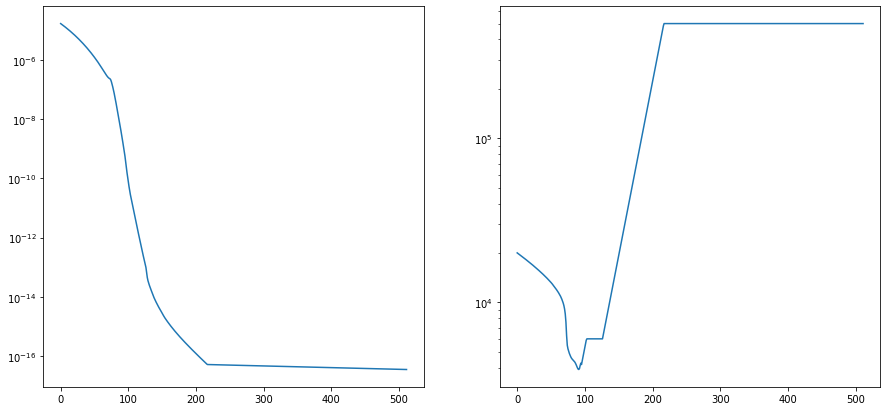

1.145e+14


In [12]:
plt.figure(figsize=(15,7))
plt.subplot(121)
plt.plot(rho)
plt.yscale("log")
plt.subplot(122)
plt.plot(eos.interp_T(eint/rho,rho))
plt.yscale("log")
plt.show()

# Value of eont/rho corresonding to 500,000K at top of domain. Use this later for the top boundary
print(f"{eint[-1]/rho[-1]:.3e}")

In [13]:
# For the magnetic field we use a potential field extrapolation. This routine assumes horizontal periodicity.

# Assumes z is vertical, note that MURaM has x as vertical. Scale is the ratio of vertical to horizontal grid spacing. 
def const_alpha_extrapolate(Bz0,z,scale=1.0,alpha=0):
 
    Nx=Bz0.shape[0]
    Ny=Bz0.shape[1]    
    Nz=z.shape[0]
    
    print(Nx,Ny,Nz)
    
    fftBz0=np.fft.fft2(Bz0)
    
    kx = np.zeros([Nx])
    ky = np.zeros([Ny])

    kx[0:Nx//2] = np.arange(Nx//2)/Nx
    kx[Nx//2:Nx] = np.arange(Nx//2)/Nx-0.5

    kx=np.array([kx[:],]*Ny).transpose()  
    kx *= 2*np.pi

    ky[0:Ny//2] = np.arange(Ny//2)/Ny
    ky[Ny//2:] = np.arange(Ny//2)/Ny-0.5

    ky = np.array([ky[:],]*Nx)
    ky *= 2*np.pi

    k2 = kx*kx + ky*ky
    w2 = k2 - alpha**2
    wabs = np.zeros([Nx,Ny],dtype=complex)
    wabs = np.sqrt(w2.clip(0,None))+1j*np.sqrt(-w2.clip(None,0))
    
    HxB = np.zeros([Nx,Ny],dtype=complex)
    HyB = np.zeros([Nx,Ny],dtype=complex)
    HzB = np.ones([Nx,Ny],dtype=complex)

    HxB[np.where(k2 != 0)] = -1j*kx[np.where(k2 != 0)]*wabs[np.where(k2 != 0)]/k2[np.where(k2 != 0)]+1j*alpha*ky[np.where(k2 != 0)]/k2[np.where(k2 != 0)]
    HxB[0,0] = -1j

    HyB[np.where(k2 != 0)] = -1j*ky[np.where(k2 != 0)]*wabs[np.where(k2 != 0)]/k2[np.where(k2 != 0)]-1j*alpha*kx[np.where(k2 != 0)]/k2[np.where(k2 != 0)]
    HyB[0,0] = -1j
     
    Bx_ext=np.zeros([Nz,Nx,Ny],dtype=np.float32,order='F')
    By_ext=np.zeros([Nz,Nx,Ny],dtype=np.float32,order='F')
    Bz_ext=np.zeros([Nz,Nx,Ny],dtype=np.float32,order='F')
    
    for i in range(0,Nz):
        
        if(i%50==0):
            print(i)
            
        z_exp=z[i]*scale
        Bx_ext[i,:,:] = np.fft.ifft2(fftBz0*HxB*np.exp(-wabs*z_exp)).real
        By_ext[i,:,:] = np.fft.ifft2(fftBz0*HyB*np.exp(-wabs*z_exp)).real
        Bz_ext[i,:,:] = np.fft.ifft2(fftBz0*HzB*np.exp(-wabs*z_exp)).real
    
    return Bx_ext,By_ext,Bz_ext

In [14]:
z=np.arange(0,nx_top-nx_merge,1)
By,Bz,Bx=const_alpha_extrapolate(snap.Bx[nx_merge,:,:],z,scale=dx/dy,alpha=0.0)

192 192 417
0
50
100
150
200
250
300
350
400


In [15]:
# Now save the expanded atmosphere. Note that we initialize a new variable "result_prim_8" with zeros. 
# This variable is needed for the conductive heat flux (hyperbolic treatment).

iter=0

filename = f"Header.{iter:06d}"
filepath = os.path.join(path_in, filename)
header = np.loadtxt(filepath, dtype=np.float32)
    
header[0]=nx_top
print(header)

filename = f"Header.{iter:06d}"
filepath = os.path.join(path_out, filename)
string=f"{header[0]:0.0f} {header[1]:0.0f} {header[2]:0.0f} {header[3]:E} {header[4]:E} {header[5]:E} {header[6]:E} {header[7]:E} {header[8]:E}"
with open(filepath, "w") as text_file:
    text_file.write(string)


data=np.zeros((nx_top,ny,nz),dtype=np.float32,order='F')
data[0:nx_merge,:,:]=snap.rho[0:nx_merge,:,:]
for i in range(nx_merge,nx_top):
    data[i,:,:]=rho[i]

filename = f"result_prim_0.{iter:06d}"
files_out=os.path.join(path_out, filename)
data.transpose([2,1,0]).tofile(files_out)

data=np.zeros((nx_top,ny,nz),dtype=np.float32,order='F')
data[0:nx_merge,:,:]=snap.vx[0:nx_merge,:,:]

filename = f"result_prim_1.{iter:06d}"
files_out=os.path.join(path_out, filename)
data.transpose([2,1,0]).tofile(files_out)

data=np.zeros((nx_top,ny,nz),dtype=np.float32,order='F')
data[0:nx_merge,:,:]=snap.vy[0:nx_merge,:,:]

filename = f"result_prim_2.{iter:06d}"
files_out=os.path.join(path_out, filename)
data.transpose([2,1,0]).tofile(files_out)

data=np.zeros((nx_top,ny,nz),dtype=np.float32,order='F')
data[0:nx_merge,:,:]=snap.vz[0:nx_merge,:,:]

filename = f"result_prim_3.{iter:06d}"
files_out=os.path.join(path_out, filename)
data.transpose([2,1,0]).tofile(files_out)

data=np.zeros((nx_top,ny,nz),dtype=np.float32,order='F')
data[0:nx_merge,:,:]=snap.eint[0:nx_merge,:,:]
for i in range(nx_merge,nx_top):
    data[i,:,:]=eint[i]

filename = f"result_prim_4.{iter:06d}"
files_out=os.path.join(path_out, filename)
data.transpose([2,1,0]).tofile(files_out)

data=np.zeros((nx_top,ny,nz),dtype=np.float32,order='F')
data[0:nx_merge,:,:]=snap.Bx[0:nx_merge,:,:]
data[nx_merge:,:,:]=Bx

filename = f"result_prim_5.{iter:06d}"
files_out=os.path.join(path_out, filename)
data.transpose([2,1,0]).tofile(files_out)

data=np.zeros((nx_top,ny,nz),dtype=np.float32,order='F')
data[0:nx_merge,:,:]=snap.By[0:nx_merge,:,:]
data[nx_merge:,:,:]=By

filename = f"result_prim_6.{iter:06d}"
files_out=os.path.join(path_out, filename)
data.transpose([2,1,0]).tofile(files_out)

data=np.zeros((nx_top,ny,nz),dtype=np.float32,order='F')
data[0:nx_merge,:,:]=snap.Bz[0:nx_merge,:,:]
data[nx_merge:,:,:]=Bz

filename = f"result_prim_7.{iter:06d}"
files_out=os.path.join(path_out, filename)
data.transpose([2,1,0]).tofile(files_out)

data=np.zeros((nx_top,ny,nz),dtype=np.float32,order='F')
filename = f"result_prim_8.{iter:06d}"
files_out=os.path.join(path_out, filename)
data.transpose([2,1,0]).tofile(files_out)

[5.12e+02 1.92e+02 1.92e+02 3.20e+06 4.80e+06 4.80e+06 0.00e+00 0.00e+00
 0.00e+00]


In [16]:
# Now run the Coronal simulation. Note that fully relaxing a corona takes typically a few hours of solar time, but is faster in this small domain, which is strongly forced boy boundaries.
# The parameters.dat file has settings for a typical coronal run. For this setup we impose a hot plate at the top with an value of eint/rho=1.145e14, which maintaines the 500,000K initial corona temperature through heat conduction.

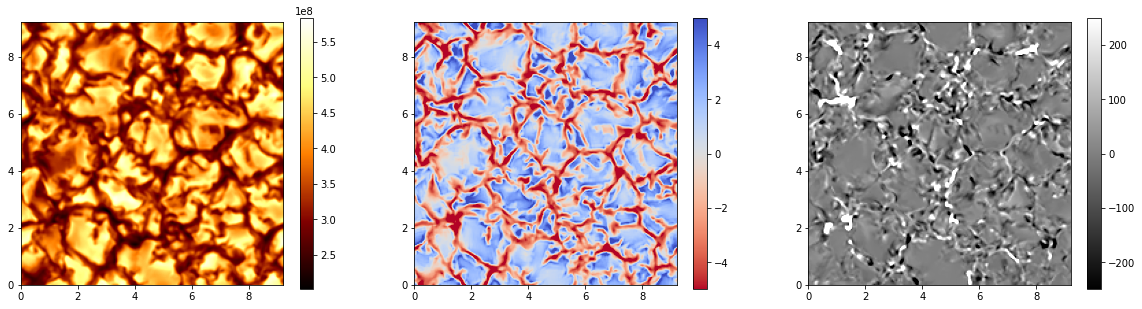

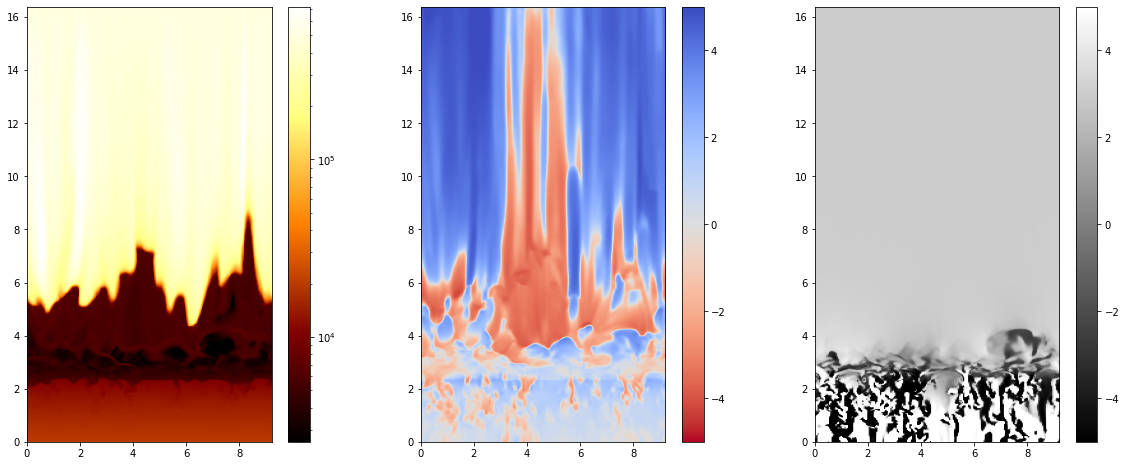

In [17]:
iter=20000

h_ext=[0,9.216,0,9.216]
v_ext=[0,9.216,0,16.384]

I500=muram.MuramIntensity('./Corona/2D/',iter)
tau=muram.MuramTauSlice('./Corona/2D/',iter,1)
xy=muram.MuramSlice('./Corona/2D/',iter,'xy','0000')

plt.figure(figsize=(20,5))
plt.subplot(131)
plt.imshow(I500.T,origin='lower',cmap='afmhot',extent=h_ext)
plt.colorbar()
plt.subplot(132)
plt.imshow(tau.vx.T/1e5,origin='lower',cmap='coolwarm_r',vmin=-5,vmax=5,extent=h_ext)
plt.colorbar()
plt.subplot(133)
plt.imshow(tau.Bx.T,origin='lower',cmap='gray',vmin=-250,vmax=250,extent=h_ext)
plt.colorbar()
plt.show()

plt.figure(figsize=(20,8))
plt.subplot(131)
plt.imshow(xy.Temp.T,origin='lower',cmap='afmhot',norm=LogNorm(),extent=v_ext)
plt.colorbar()
plt.subplot(132)
plt.imshow(np.arcsinh(xy.vx.T/1e5),origin='lower',cmap='coolwarm_r',vmin=-5,vmax=5,extent=v_ext)
plt.colorbar()
plt.subplot(133)
plt.imshow(np.arcsinh(xy.Bx.T),origin='lower',cmap='gray',vmin=-5,vmax=5,extent=v_ext)
plt.colorbar()
plt.show()

In [18]:
# Read full 3D data
iter=20000
snap=muram.MuramSnap('./Corona/3D/',iter)
snap.available

['rho',
 'vx',
 'vy',
 'vz',
 'eint',
 'Bx',
 'By',
 'Bz',
 'sflx',
 'Temp',
 'Pres',
 'ne',
 'Q',
 'tau',
 'QxCor',
 'Qres',
 'Qvis']

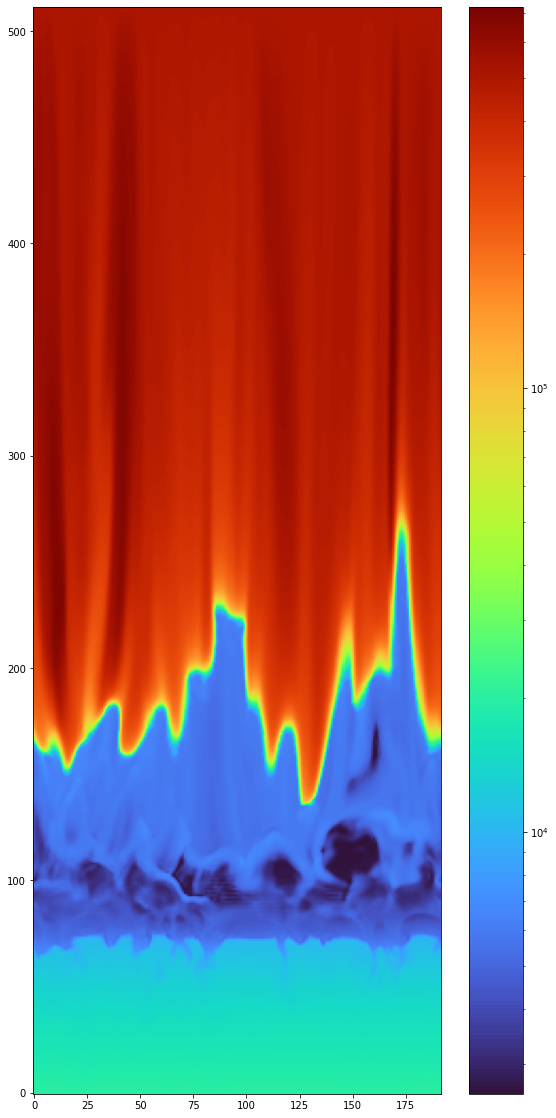

In [19]:
plt.figure(figsize=(10,20))
plt.imshow(snap.Temp[:,:,0],origin='lower',norm=LogNorm(),cmap='turbo')
plt.colorbar()

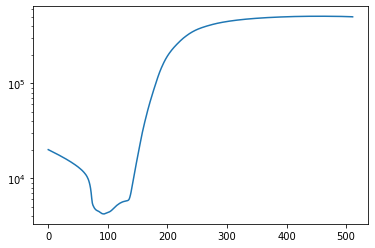

In [20]:
plt.plot(np.mean(snap.Temp,axis=(1,2)))
plt.yscale("log")

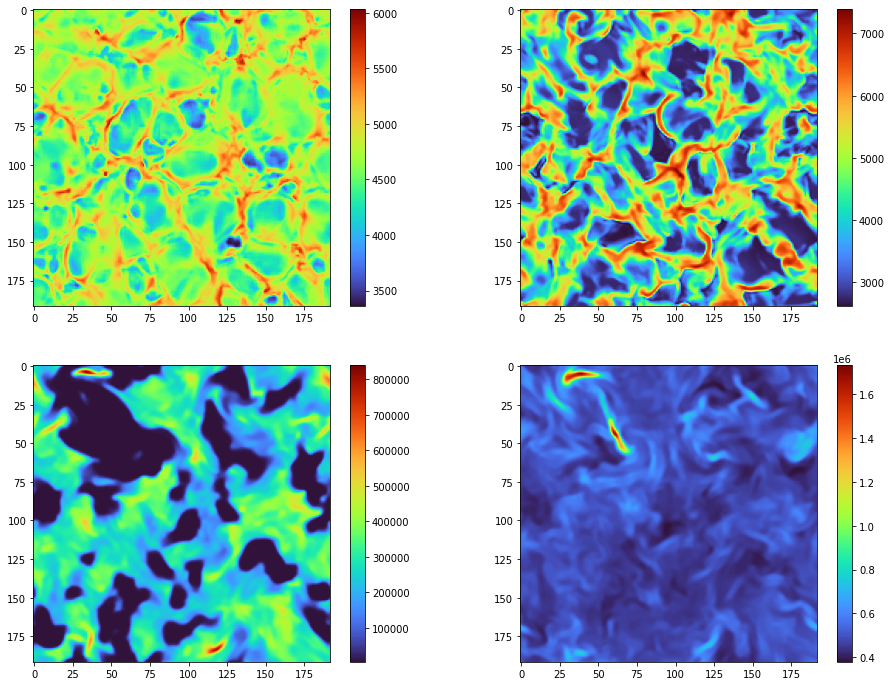

In [21]:
plt.figure(figsize=(16,12))
plt.subplot(221)
plt.imshow(snap.Temp[80,:,:],cmap='turbo')
plt.colorbar()
plt.subplot(222)
plt.imshow(snap.Temp[100,:,:],cmap='turbo')
plt.colorbar()
plt.subplot(223)
plt.imshow(snap.Temp[200,:,:],cmap='turbo')
plt.colorbar()
plt.subplot(224)
plt.imshow(snap.Temp[400,:,:],cmap='turbo')
plt.colorbar()

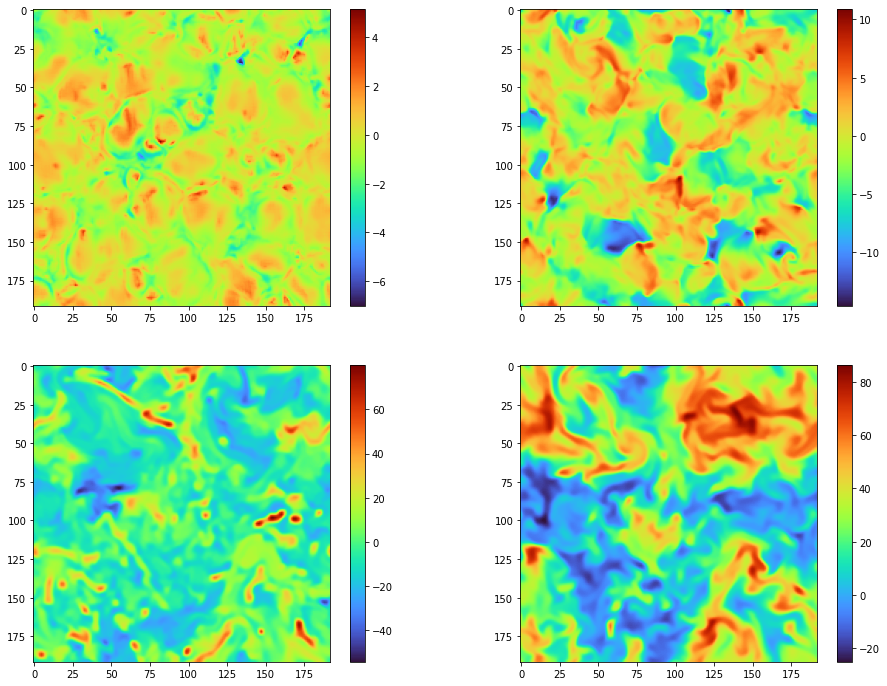

In [22]:
plt.figure(figsize=(16,12))
plt.subplot(221)
plt.imshow(snap.vx[80,:,:]/1e5,cmap='turbo')
plt.colorbar()
plt.subplot(222)
plt.imshow(snap.vx[100,:,:]/1e5,cmap='turbo')
plt.colorbar()
plt.subplot(223)
plt.imshow(snap.vx[200,:,:]/1e5,cmap='turbo')
plt.colorbar()
plt.subplot(224)
plt.imshow(snap.vx[400,:,:]/1e5,cmap='turbo')
plt.colorbar()

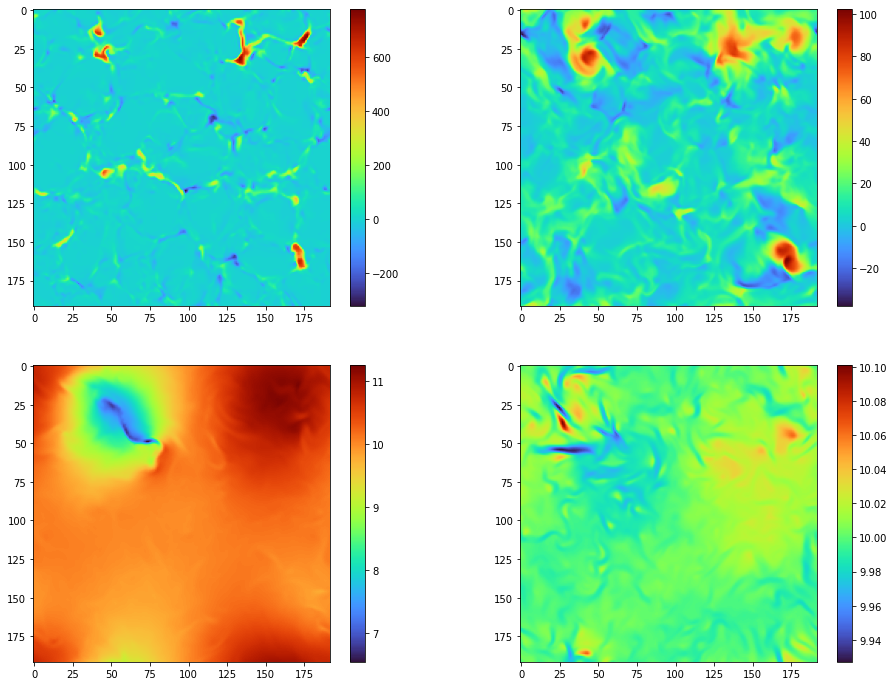

In [23]:
plt.figure(figsize=(16,12))
plt.subplot(221)
plt.imshow(snap.Bx[80,:,:]*np.sqrt(4*np.pi),cmap='turbo')
plt.colorbar()
plt.subplot(222)
plt.imshow(snap.Bx[100,:,:]*np.sqrt(4*np.pi),cmap='turbo')
plt.colorbar()
plt.subplot(223)
plt.imshow(snap.Bx[200,:,:]*np.sqrt(4*np.pi),cmap='turbo')
plt.colorbar()
plt.subplot(224)
plt.imshow(snap.Bx[400,:,:]*np.sqrt(4*np.pi),cmap='turbo')
plt.colorbar()